In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
spark = SparkSession.builder.appName('sharingBikeDatamining').getOrCreate()

In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [3]:
gt = pd.read_csv('/home/ubuntu/722-gt/GlobalTemperatures.csv')

In [4]:
# variables data type
gt.dtypes

dt                                            object
LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object

# 2.Data Understanding


## 2.2. Describe the data

In [5]:
gt.describe()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,3180.000000,3180.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,8.374731,0.938468,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,4.381310,1.096440,4.309579,0.583203,4.155835,0.445838,1.274093,0.073587
min,-2.080000,0.034000,5.900000,0.044000,-5.407000,0.045000,12.475000,0.042000
25%,4.312000,0.186750,10.212000,0.142000,-1.334500,0.155000,14.047000,0.063000
50%,8.610500,0.392000,14.760000,0.252000,2.949500,0.279000,15.251000,0.122000
75%,12.548250,1.419250,18.451500,0.539000,6.778750,0.458250,16.396250,0.151000
max,19.021000,7.880000,21.320000,4.373000,9.715000,3.498000,17.611000,0.457000


[Text(0,0.5,'Count'),
 Text(0.5,0,'variableTypeariable Type'),
 Text(0.5,1,'Variables DataType Count')]

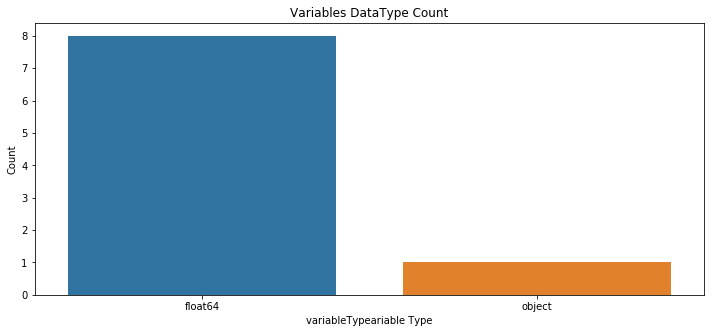

In [6]:
dataTypeDf = pd.DataFrame(gt.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

## 

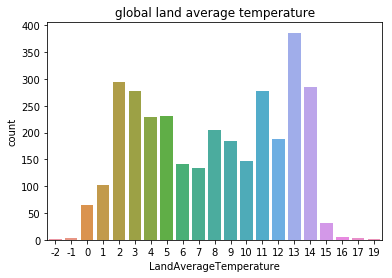

In [7]:
fig,ax = plt.subplots()
gt.LandAverageTemperature = gt.LandAverageTemperature.fillna(0.0).astype(int)
ax.set(xlabel='LandAverageTemperature', ylabel='count',title="global land average temperature")
sn.countplot(data=gt, x="LandAverageTemperature")

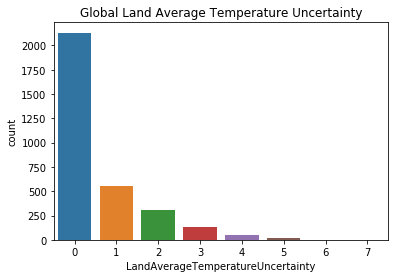

In [8]:
fig,ax = plt.subplots()
gt.LandAverageTemperatureUncertainty = gt.LandAverageTemperatureUncertainty.fillna(0.0).astype(int)
ax.set(xlabel='LandAverageTemperatureUncertainty', ylabel='count',title="Global Land Average Temperature Uncertainty")
sn.countplot(data=gt, x="LandAverageTemperatureUncertainty")

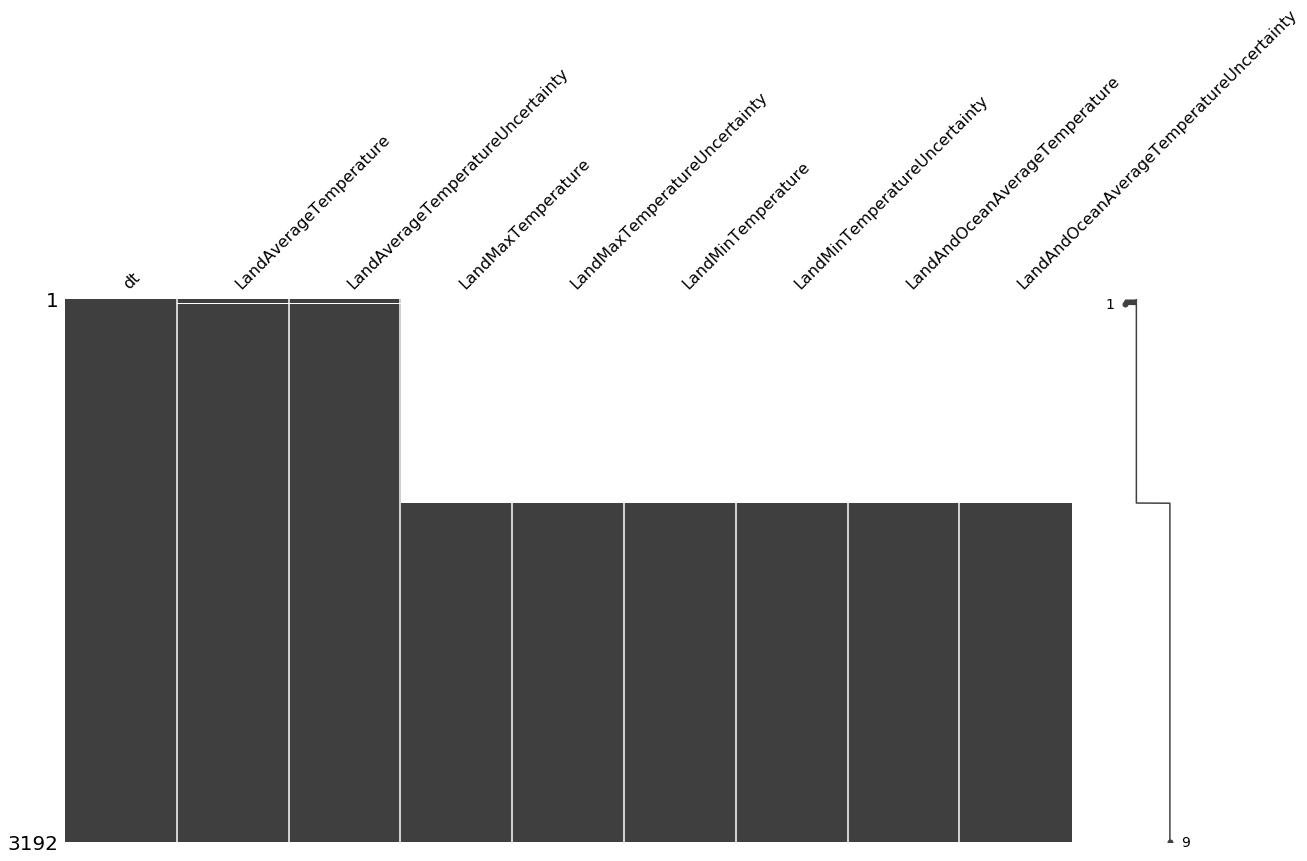

In [9]:
import pyspark.sql.functions as fn
gt2 = pd.read_csv('/home/ubuntu/722-gt/GlobalTemperatures.csv')
# missing value detect
msno.matrix(gt2,figsize=(20,10))

In [10]:
gt2.dropna(axis=0, how='any', inplace=True)

# 3.Data Preparation

## 3.1 select data

In [11]:
gt2['dt'] = pd.to_datetime(gt2['dt'], errors='coerce')
gt2 = gt2.set_index('dt')
gt3 = gt2['1850':'2015']
gt3.head(10)

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249
1850-06-01,13.150,0.614,18.946,2.817,7.106,0.857,16.353,0.245
1850-07-01,14.492,0.614,19.233,2.840,8.014,0.786,16.783,0.238
1850-08-01,14.039,0.802,18.477,2.079,7.406,1.086,16.718,0.280
1850-09-01,11.505,0.675,15.846,2.692,4.533,1.798,15.886,0.254


## 3.2 Clean the data

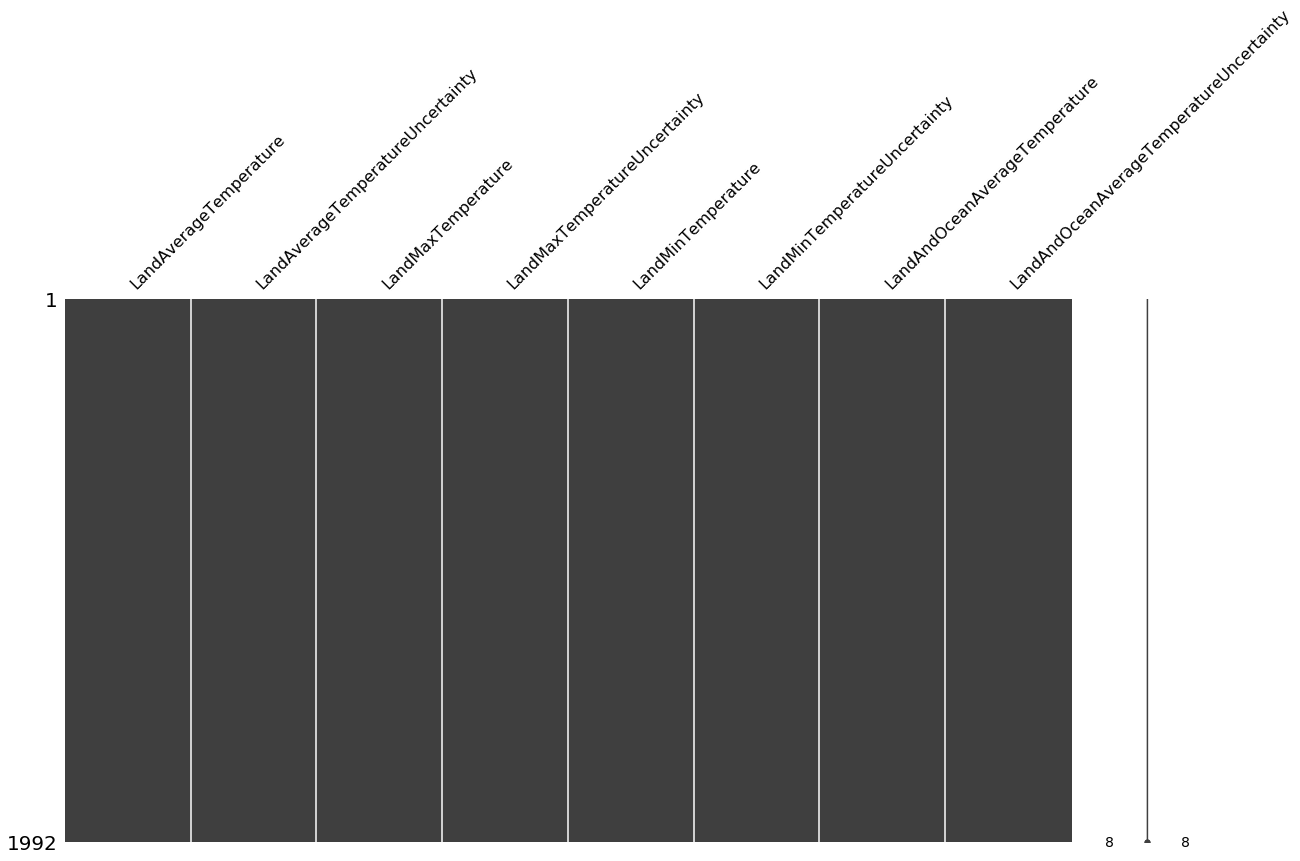

In [12]:
# missing value detect
msno.matrix(gt3,figsize=(20,10))

## 3.3 Construct the data

## 3.4 Integrate various data sources

## 3.5. Format the data

# 4. Data transformation

## 4.1. Reduce the data

In [13]:
# outliers function

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

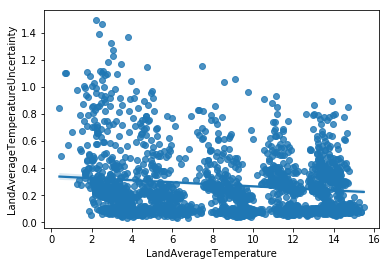

In [14]:
sn.regplot(x="LandAverageTemperature", y="LandAverageTemperatureUncertainty", data=gt3)

In [15]:
# eliminating outliers
gt4 = remove_outlier(gt3, 'LandAverageTemperatureUncertainty')

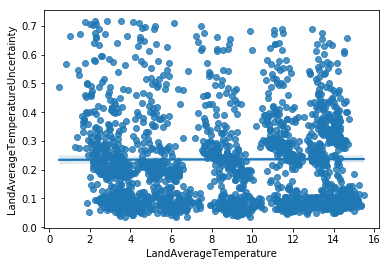

In [16]:
sn.regplot(x="LandAverageTemperature", y="LandAverageTemperatureUncertainty", data=gt4)

## 4.2. Project the data

# 5. Data- mining methods selection

# 6. Data-mining algorithms selection

## 6.3 Select/Build the most appropriate model/algorithm parameters

#### We will select the most appropriate parameters from pyspark.ml.regression.LinearRegression, which is shown in the table below:
<img src="6.3-1.png" width="100%">
<img src="6.3-2.png" width="100%">
<img src="6.3-3.png" width="100%">

#### It is a relatively simple algorithm such that linear regression is evaluated based on the linear model of equation y = mx + c. therefore, we will need to fit the linear model first with using parameter x and y. In order to fit the linear model, we are using parameter x and y, which represent ‘MaxTemperature’ and ‘MinTemperature’.
#### As for the accuracy of the prediction, two factors need to be considered. Firstly, 2 statistical error measurements will be used to calculate whether our algorithms are accurate.

# 7. Data mining

## 7.1. Logical test design

In [18]:
# convert panadas data frame into spark data frame

from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler

sqlContext = SQLContext(spark)
spark_gt = sqlContext.createDataFrame(gt4)

vectorAssembler = VectorAssembler(inputCols = ['LandMinTemperature'],
                                  outputCol = 'features')
gt_model_matrix = vectorAssembler.transform(spark_gt)

gt_model_matrix = gt_model_matrix.select(['features', 'LandMaxTemperature'])
gt_model_matrix.printSchema()

root
 |-- features: vector (nullable = true)
 |-- LandMaxTemperature: double (nullable = true)



In [19]:
# Spliting data

splits = gt_model_matrix.randomSplit([0.7, 0.3])

train_df = splits[0]
test_df = splits[1]

train_df.describe().show()
test_df.describe().show()

+-------+------------------+
|summary|LandMaxTemperature|
+-------+------------------+
|  count|              1305|
|   mean|14.584828352490424|
| stddev| 4.268757508553695|
|    min| 6.678999999999999|
|    max|             21.32|
+-------+------------------+

+-------+------------------+
|summary|LandMaxTemperature|
+-------+------------------+
|  count|               567|
|   mean|  14.4462962962963|
| stddev| 4.277870791966505|
|    min|               5.9|
|    max|            21.085|
+-------+------------------+



## 7.2 Data Mining

In [23]:
# building model

from pyspark.ml.regression import LinearRegression
# Instantiate the instance.
# 
lr = LinearRegression(featuresCol='features', labelCol='LandMaxTemperature', maxIter=15, regParam=0.9, elasticNetParam=0.5)

# elasticNetParam ---> alpha: 0-ridge;1-lasso;
# Fit the training data.
lr_model = lr.fit(train_df)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary

print("Root Mean Squared Error: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)
#print("r2: %f" % trainingSummary.r2)

Coefficients: [0.8372135136066033]
Intercept: 12.084004225340658

Root Mean Squared Error: 0.940224
R2: 0.951450


## 7.3. Search for pattern


#### Looking at RMSE and R2, we can see that the model is quite accurate. The RMSE shows that, on average, there's only a 0.87 degrees celsius discrepancy between the actual and predicted results. Comparing this to the table below, the average amount spent 14.5 degrees celsius  and standard deviation 4.2 degrees celsius, a 0.87 degrees celsius error is surprisingly good.

In [22]:
gt_model_matrix.describe().show()

+-------+------------------+
|summary|LandMaxTemperature|
+-------+------------------+
|  count|              1872|
|   mean|14.542869123931634|
| stddev| 4.270850925952951|
|    min|               5.9|
|    max|             21.32|
+-------+------------------+



# 8. Interpretation

## 8.1. Study and discuss the mined pattern

## 8.2. Visualise the data, results, models and patterns

In [ ]:
sn.pointplot(x=gt["dt"], y=gt["LandMaxTemperature"],hue=gt["dt"], data=gt, join=True)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')